## 라이브러리 가져오기

In [1]:
# import libraries
import pandas as pd
import numpy as np
import glob
import os
import math
from itertools import chain, repeat
import shutil #used to zip predictions for submission

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

from dtwalign import dtw
from dtwalign import dtw_from_distance_matrix
from scipy.ndimage import gaussian_filter
from scipy import interpolate

# import sklearn libararies
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import xgboost
import lightgbm
# import dtw

np.random.seed(10)

c:\Users\DELL\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 데이터 불러오기

In [2]:
well_list = os.listdir('data/train/')

if '.DS_Store' in well_list:
    well_list.remove('.DS_Store')

per_well = []

for i in well_list:
    well = pd.read_csv('data/train/{}'.format(i))
    well['log_RD'] = np.log10(well['RD'])
    well['well'] = i.split('_')[-1].split('.')[0]
    per_well.append(well)

## ZONATION

### 1) 기울기를 이용한 Zonation

In [20]:
for i in per_well:
    # Median filter

    window_size = 200
    GR_median = []
    for j in range(len(i)):
        if j < window_size//2 :
            GR_median.append(np.median(i['GR'][:j]))
        elif j > len(i) - window_size//2 :
            GR_median.append(np.median(i['GR'][j-window_size//2:-1]))
        else:
            GR_median.append(np.median(i['GR'][j-window_size//2:j+window_size//2]))
            window_size2 = 100
    
    GR_median_2 = []
    for k in range(len(GR_median)//window_size2):
        GR_median_2.append(GR_median[window_size2*k])
    GR_median_2.append(GR_median[-1])
   
    GR_df = []
    for l in range(len(GR_median_2)-1):
        GR_df.append(GR_median_2[l+1]-GR_median_2[l])

    zone = []
    thr = 3
    for m in range(len(GR_df)):
        if GR_df[m] > thr:
            zone.append(2)
        elif GR_df[m] < -thr :
            zone.append(0)
        else:
            zone.append(1)
    zone_2 = list(chain.from_iterable((repeat(number, window_size2) for number in zone[:-1])))
    zone_2 = zone_2 + [zone[-1]] * (len(GR_median)- len(zone_2))
    i['Zone'] = zone_2
per_well2 = pd.concat(per_well)

c:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\DELL\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\DELL\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\DELL\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\DELL

### 2) Sand/Shale Zonation

In [3]:
per_well2 = pd.concat(per_well)
per_well2.loc[per_well2['GR']>=75, 'Zone'] = 0
per_well2.loc[per_well2['GR']<75, 'Zone'] = 1

### 3) 정성적 Zonation

In [3]:
per_well[0].loc[:, 'Zone'] = 2
per_well[0].loc[per_well[0]['DEPT']<=3649.5, 'Zone'] = 1
per_well[0].loc[per_well[0]['DEPT']<=2428, 'Zone'] = 0

per_well[1].loc[:, 'Zone'] = 2
per_well[1].loc[per_well[1]['DEPT']<=3217, 'Zone'] = 1
per_well[1].loc[per_well[1]['DEPT']<=2084.5, 'Zone'] = 0

per_well[2].loc[:, 'Zone'] = 2
per_well[2].loc[per_well[2]['DEPT']<=3110.5, 'Zone'] = 1
per_well[2].loc[per_well[2]['DEPT']<=1991, 'Zone'] = 0

per_well[3].loc[:, 'Zone'] = 2
per_well[3].loc[per_well[3]['DEPT']<=3022.5, 'Zone'] = 1

per_well[4].loc[:, 'Zone'] = 2
per_well[4].loc[per_well[4]['DEPT']<=2920, 'Zone'] = 1
per_well[4].loc[per_well[4]['DEPT']<=1805, 'Zone'] = 0

per_well[5].loc[:, 'Zone'] = 2
per_well[5].loc[per_well[5]['DEPT']<=3024.5, 'Zone'] = 1

per_well[6].loc[:, 'Zone'] = 2
per_well[6].loc[per_well[6]['DEPT']<=2990, 'Zone'] = 1
per_well[6].loc[per_well[6]['DEPT']<=1893.5, 'Zone'] = 0

per_well[7].loc[:, 'Zone'] = 2
per_well[7].loc[per_well[7]['DEPT']<=3018, 'Zone'] = 1
per_well[7].loc[per_well[7]['DEPT']<=1905.5, 'Zone'] = 0

per_well[8].loc[:, 'Zone'] = 2
per_well[8].loc[per_well[8]['DEPT']<=3778, 'Zone'] = 1
per_well[8].loc[per_well[8]['DEPT']<=1693.5, 'Zone'] = 0

per_well2 = pd.concat(per_well)

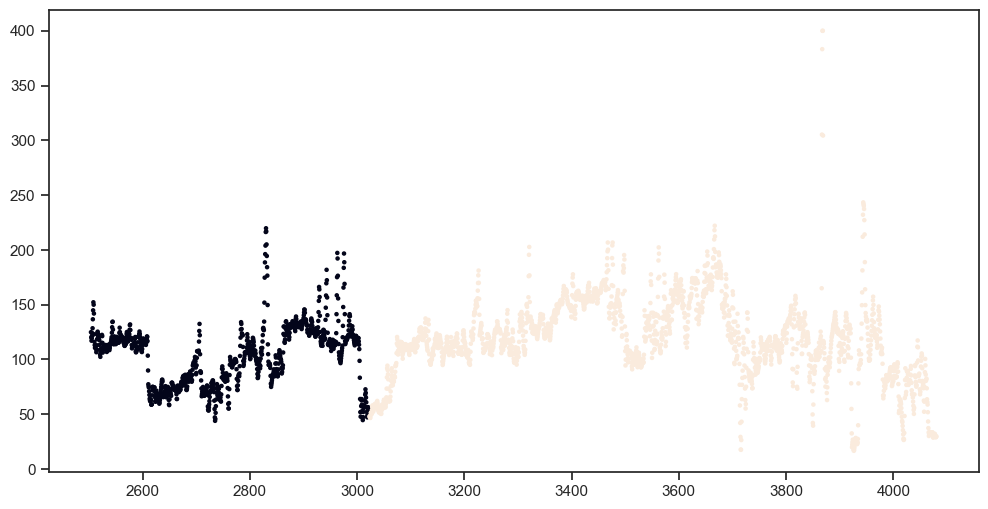

In [111]:
plt.figure(figsize=(12,6))
plt.scatter(per_well[3]['DEPT'], per_well[3]['GR'], c=per_well[3]['Zone'], s=5)

## 이상치 제거

In [4]:
features=['GR','RHOB','NPHI','log_RD','DEPT']
clf = IsolationForest(random_state=0).fit_predict(per_well2[features])
a = per_well2.copy()
per_well2 = per_well2[clf==1]

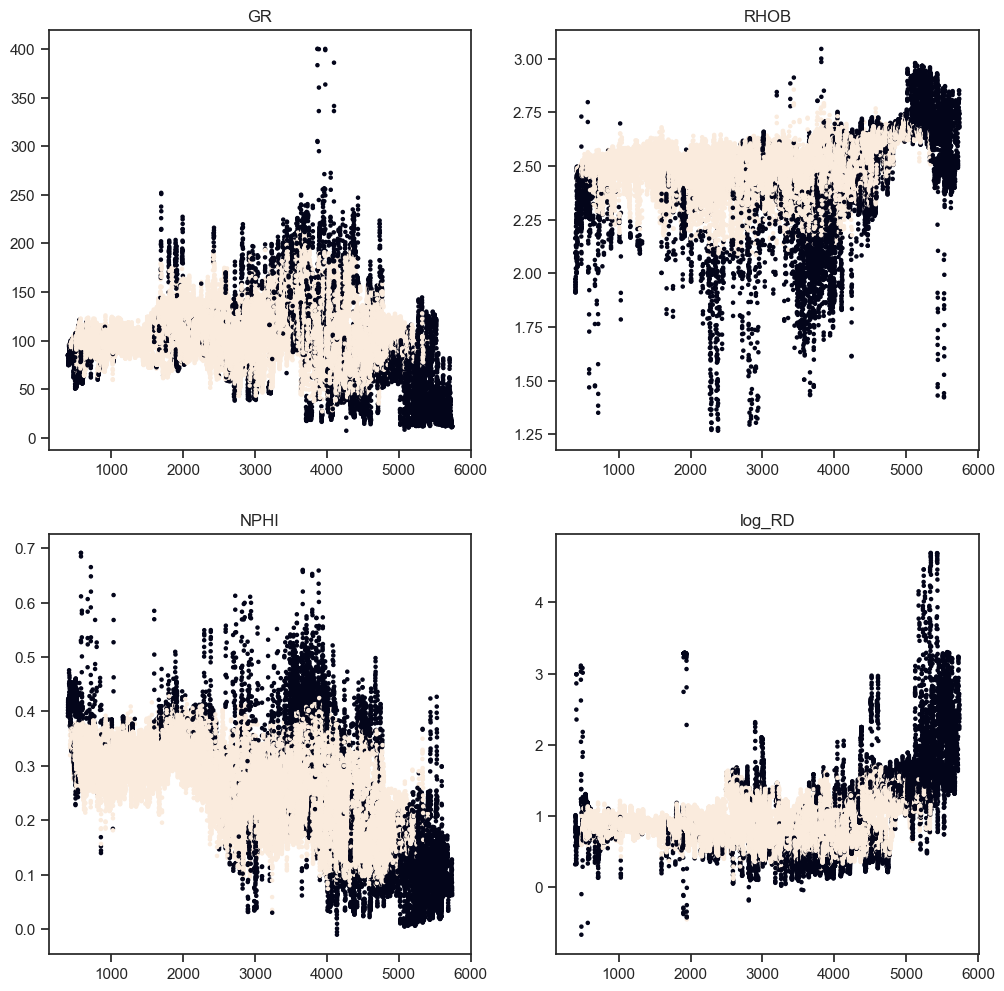

In [5]:
plt.figure(figsize=(12,12))
b = {2: 'True', 0: 'False'}
for _, i in enumerate(features[0:4]):
    plt.subplot(2, 2, _+1)
    plt.scatter(a['DEPT'], a[i], c=clf, s=5)
    plt.title('{}'.format(i))
# plt.colorbar()
# White: 이상치 Black: 정상

## DTW 분석

#### * 데이터 분석을 위한 DTW 분석 과정으로 모델 학습할 때는 안 돌려도 됨

In [101]:
alignment = dtw.dtw(query_well, ref_well, step_pattern='asymmetric', keep_internals=True)

<Axes: xlabel='Index', ylabel='Query value'>

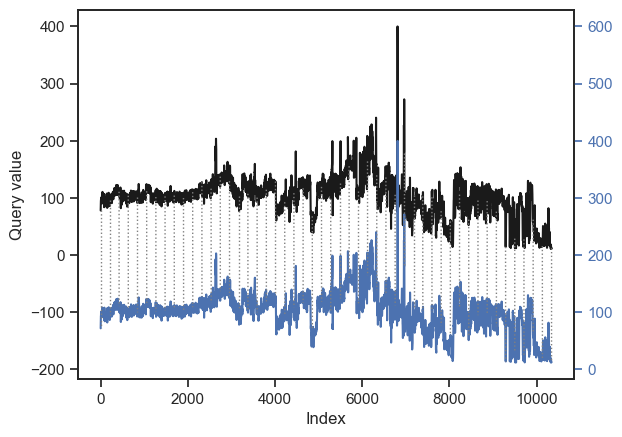

In [102]:
alignment.plot(type='twoway', offset=-200)

<Axes: xlabel='Index', ylabel='Query value'>

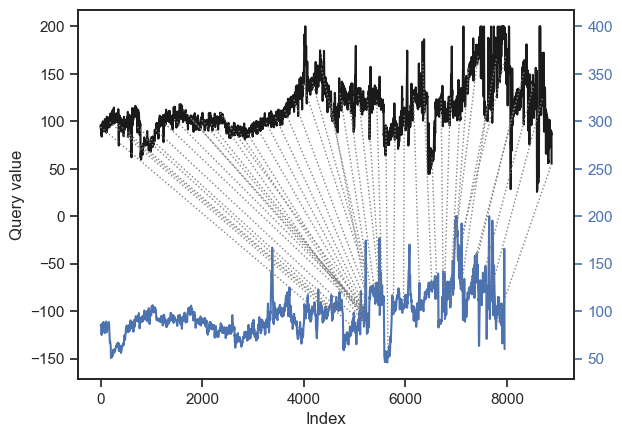

In [115]:
# index_t = {}
q, r = 0, 1
alignment = dtw.dtw(per_well[q]['GR'], per_well[r]['GR'], step_pattern='asymmetric', keep_internals=True, open_end=True, open_begin=True)
alignment.plot(type='twoway', offset=-200)
# index_t['{}_{} query'.format(q, r)]= alignment.index1
# index_t['{}_{} ref'.format(q, r)] = alignment.index2

In [40]:
index_t

{'1_0 query': array([   0,    1,    2, ..., 7952, 7953, 7954]),
 '1_0 ref': array([5575, 5575, 5575, ..., 7720, 7720, 7720], dtype=int64),
 '2_0 query': array([   0,    1,    2, ..., 7590, 7591, 7592]),
 '2_0 ref': array([ 946,  946,  946, ..., 8822, 8822, 8822], dtype=int64),
 '3_0 query': array([   0,    1,    2, ..., 3152, 3153, 3154]),
 '3_0 ref': array([5480, 5480, 5480, ..., 8880, 8880, 8880], dtype=int64),
 '0_4 query': array([   0,    1,    2, ..., 8878, 8879, 8880]),
 '0_4 ref': array([   3,    3,    3, ..., 6946, 6947, 6949], dtype=int64),
 '5_0 query': array([   0,    1,    2, ..., 3518, 3519, 3520]),
 '5_0 ref': array([5151, 5151, 5151, ..., 8614, 8614, 8614], dtype=int64),
 '0_6 query': array([   0,    1,    2, ..., 8878, 8879, 8880]),
 '0_6 ref': array([   2,    2,    2, ..., 6952, 6952, 6952], dtype=int64),
 '7_0 query': array([   0,    1,    2, ..., 7281, 7282, 7283]),
 '7_0 ref': array([3101, 3101, 3101, ..., 8793, 8793, 8793], dtype=int64),
 '0_8 query': array([   0, 

In [50]:
index_t['1_0 ref'].shape

(7955,)

In [52]:
Data.loc[index_t['1_0 ref'], 'GR']

5575     85.166
5575     85.166
5575     85.166
5575     85.166
5575     85.166
         ...   
7719    140.626
7720    111.569
7720    111.569
7720    111.569
7720    111.569
Name: GR, Length: 7955, dtype: float64

In [75]:
Data.loc[Data['Zone']==-1, 'Zone'] = 0

In [91]:
index_t['1_0 ref'].min(), index_t['1_0 ref'].max()

(5575, 7720)

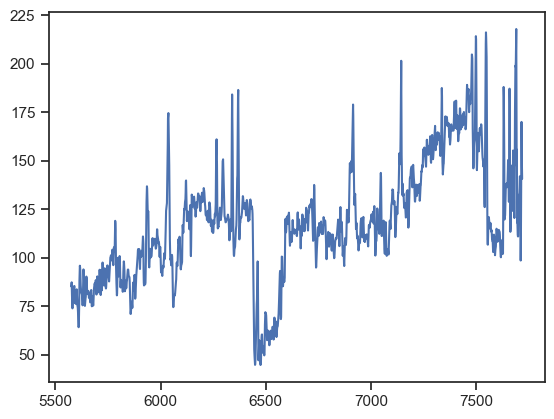

In [103]:
plt.plot(Data.iloc[5575:7720,2])

In [ ]:
for i in range(9):
    for j in range(9):
        query_well = per_well[i]['GR']
        ref_well = per_well[j]['GR']
        try:
            alignment = dtw.dtw(query_well, ref_well, step_pattern='asymmetric', keep_internals=True, open_end=True, open_begin=True)
            alignment.plot(type='twoway', offset=-200)
            # plt.savefig('DTW/open_{}_{}.png'.format(i, j))
        except ValueError:
            print('ValueError_{}_{}'.format(i,j))
            alignment = dtw.dtw(ref_well, query_well, step_pattern='asymmetric', keep_internals=True)
            alignment.plot(type='twoway', offset=-200)
            # plt.savefig('DTW/open_{}_{}.png'.format(i, j))
        

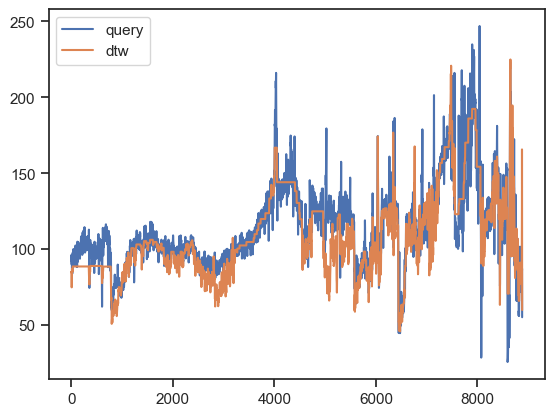

In [48]:
plt.plot(query_well, label='query')
plt.plot(alignment.index1,ref_well[alignment.index2], label='dtw')
plt.legend()

In [ ]:
## DTW 인덱스 엑셀 파일로 추출

a1 = pd.Series(alignment.index1)
a2 = pd.Series(alignment.index2)
a = pd.DataFrame(np.concatenate((alignment.index1.reshape((-1,1)), alignment.index2.reshape((-1,1))), axis=1), columns=['index1', 'index2'])
a.to_excel('dtw_index.xlsx')

## 학습 데이터 분할

### 1) 학습 데이터를 Well 단위로 분할

In [6]:
## 학습 데이터를 Well 단위로 분할
well_n = per_well2['well'].unique()
np.random.shuffle(well_n)
split=0.7
n=int(np.round(len(well_n)*split))
train_well,val_well=per_well2[per_well2['well'].isin(well_n[:n])].copy(),per_well2[per_well2['well'].isin(well_n[n:])].copy()
print(well_n, n)

['09' '03' '06' '07' '04' '02' '01' '08' '05'] 6


### 2) 학습 데이터를 전체 로그 데이터에서 임의로 분할

In [41]:
## 전체 로그 데이터에서 임의로 분할
Train_data, Val_data = train_test_split(per_well[2], test_size = .2)
Feature_name = ['RHOB','NPHI','RD']

x_train, y_train = Train_data['GR'], Train_data[Feature_name]
x_val, y_val = Val_data['GR'], Val_data[Feature_name]

x_train = np.array(x_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,3)

x_val = np.array(x_val).reshape(-1,1)
y_val = np.array(y_val).reshape(-1,3)

## 학습 데이터 전처리

#### Scaler

In [7]:
scaler1 = MinMaxScaler()
train_well['DEPT'] = scaler1.fit_transform(np.asarray(train_well['DEPT']).reshape(-1,1))
val_well['DEPT'] = scaler1.transform(np.asarray(val_well['DEPT']).reshape(-1,1))


scaler2 = MinMaxScaler()
train_well['GR'] = scaler2.fit_transform(np.asarray(train_well['GR']).reshape(-1,1))
val_well['GR'] = scaler2.transform(np.asarray(val_well['GR']).reshape(-1,1))

scaler3 = MinMaxScaler()
train_well['NPHI'] = scaler3.fit_transform(np.asarray(train_well['NPHI']).reshape(-1,1))
val_well['NPHI'] = scaler3.transform(np.asarray(val_well['NPHI']).reshape(-1,1))

scaler4 = MinMaxScaler()
train_well['RHOB'] = scaler4.fit_transform(np.asarray(train_well['RHOB']).reshape(-1,1))
val_well['RHOB'] = scaler4.transform(np.asarray(val_well['RHOB']).reshape(-1,1))

scaler5 = MinMaxScaler()
train_well['log_RD'] = scaler5.fit_transform(np.asarray(train_well['log_RD']).reshape(-1,1))
val_well['log_RD'] = scaler5.transform(np.asarray(val_well['log_RD']).reshape(-1,1))

### 모델 선정 및 학습

In [8]:
y_train_pred = train_well[['DEPT', 'GR', 'Zone']].copy()
y_val_pred = val_well[['DEPT', 'GR', 'Zone']].copy()

In [233]:
# ## Zonation 안했을 경우 RF 3
# y_train_pred = train_well[['DEPT', 'GR']].copy()
# y_val_pred = val_well[['DEPT', 'GR']].copy()

# x_feat1 = ['DEPT', 'GR']
# y_feat1 = ['NPHI',]

# rf_reg = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
# rf_reg.fit(train_well[x_feat1], train_well[y_feat1])

# y_train_pred['NPHI'] = rf_reg.predict(train_well[x_feat1])
# y_val_pred['NPHI'] = rf_reg.predict(val_well[x_feat1])
# for _, feat in enumerate(y_feat1):
#     train_well['{}_pred'.format(feat)] = y_train_pred[feat]
#     val_well['{}_pred'.format(feat)] = y_val_pred[feat]


# x_feat2 = ['DEPT', 'GR', 'NPHI']
# y_feat2 = ['RHOB']


# rf_reg = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
# rf_reg.fit(train_well[x_feat2], train_well[y_feat2])

# y_train_pred['RHOB'] = rf_reg.predict(y_train_pred[x_feat2])
# y_val_pred['RHOB'] = rf_reg.predict(y_val_pred[x_feat2])
# for _, feat in enumerate(y_feat2):
#     train_well['{}_pred'.format(feat)] = y_train_pred[feat]
#     val_well['{}_pred'.format(feat)] = y_val_pred[feat]

# x_feat3 = ['DEPT', 'GR', 'NPHI', 'RHOB']
# y_feat3 = ['log_RD']


# rf_reg = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
# rf_reg.fit(train_well[x_feat3], train_well[y_feat3])

# y_train_pred['log_RD'] = rf_reg.predict(y_train_pred[x_feat3])
# y_val_pred['log_RD'] = rf_reg.predict(y_val_pred[x_feat3])
# for _, feat in enumerate(y_feat3):
#     train_well['{}_pred'.format(feat)] = y_train_pred[feat]
#     val_well['{}_pred'.format(feat)] = y_val_pred[feat]

C:\Users\DELL\AppData\Local\Temp\ipykernel_26320\475456701.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(train_well[x_feat1], train_well[y_feat1])
C:\Users\DELL\AppData\Local\Temp\ipykernel_26320\475456701.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(train_well[x_feat2], train_well[y_feat2])
C:\Users\DELL\AppData\Local\Temp\ipykernel_26320\475456701.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(train_well[x_feat3], train_well[y_feat3])


In [148]:
# ## Zonation 안했을 경우
# x_feat1 = ['DEPT', 'GR']
# y_feat1 = ['NPHI',]

# rf_reg = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
# rf_reg.fit(train_well[x_feat1], train_well[y_feat1])

# y_train_pred['NPHI'] = rf_reg.predict(train_well[x_feat1])
# y_val_pred['NPHI'] = rf_reg.predict(val_well[x_feat1])


# for _, feat in enumerate(y_feat1):
#     train_well['{}_pred'.format(feat)] = y_train_pred['NPHI']
#     val_well['{}_pred'.format(feat)] = y_val_pred['NPHI']



# x_feat2 = ['DEPT', 'GR', 'NPHI']
# y_feat2 = ['RHOB']


# rf_reg = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
# rf_reg.fit(train_well[x_feat2], train_well[y_feat2])

# y_train_pred['RHOB'] = rf_reg.predict(y_train_pred[x_feat2])
# y_val_pred['RHOB'] = rf_reg.predict(y_val_pred[x_feat2])
# for _, feat in enumerate(y_feat2):
#     train_well['{}_pred'.format(feat)] = y_train_pred['RHOB']
#     val_well['{}_pred'.format(feat)] = y_val_pred['RHOB']

# x_feat3 = ['DEPT', 'GR', 'NPHI', 'RHOB']
# y_feat3 = ['log_RD']


# rf_reg = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
# rf_reg.fit(train_well[x_feat3], train_well[y_feat3])

# y_train_pred['log_RD'] = rf_reg.predict(y_train_pred[x_feat3])
# y_val_pred['log_RD'] = rf_reg.predict(y_val_pred[x_feat3])
# for _, feat in enumerate(y_feat3):
#     train_well['{}_pred'.format(feat)] = y_train_pred['log_RD']
#     val_well['{}_pred'.format(feat)] = y_val_pred['log_RD']

C:\Users\DELL\AppData\Local\Temp\ipykernel_26320\727491096.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(train_well[x_feat1], train_well[y_feat1])
C:\Users\DELL\AppData\Local\Temp\ipykernel_26320\727491096.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(train_well[x_feat2], train_well[y_feat2])
C:\Users\DELL\AppData\Local\Temp\ipykernel_26320\727491096.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(train_well[x_feat3], train_well[y_feat3])


In [9]:
# Zonation한 경우 RF 3
x_feat1 = ['DEPT', 'GR']
y_feat1 = ['NPHI']

x_feat2 = ['DEPT', 'GR', 'NPHI']
y_feat2 = ['RHOB']

x_feat3 = ['DEPT', 'GR', 'NPHI', 'RHOB']
y_feat3 = ['log_RD']


r2_zone_train = np.zeros((3, len(train_well['Zone'].unique())))
r2_zone_val = np.zeros((3, len(val_well['Zone'].unique())))

models = []

for i in per_well2['Zone'].unique():
    rf_reg1 = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
    rf_reg1.fit(train_well.loc[train_well['Zone']==i, x_feat1], train_well.loc[train_well['Zone']==i, y_feat1])
    y_train_pred.loc[y_train_pred['Zone']==i,'NPHI'] = rf_reg1.predict(train_well.loc[train_well['Zone']==i, x_feat1])
    y_val_pred.loc[y_val_pred['Zone']==i,'NPHI'] = rf_reg1.predict(val_well.loc[val_well['Zone']==i, x_feat1])

    r2_zone_train[0, i] = r2_score(train_well.loc[train_well['Zone']==i, 'NPHI'], y_train_pred.loc[y_train_pred['Zone']==i,'NPHI'])
    r2_zone_val[0, i] = r2_score(val_well.loc[val_well['Zone']==i, 'NPHI'], y_val_pred.loc[y_val_pred['Zone']==i,'NPHI'])
    
    for _, j in enumerate(y_feat1):
        train_well.loc[train_well['Zone']==i, '{}_pred'.format(j)] = y_train_pred.loc[y_train_pred['Zone']==i,j]
        val_well.loc[val_well['Zone']==i, '{}_pred'.format(j)] =  y_val_pred.loc[y_val_pred['Zone']==i, j]
    
    rf_reg2 = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
    rf_reg2.fit(train_well.loc[train_well['Zone']==i, x_feat2], train_well.loc[train_well['Zone']==i, y_feat2])
    y_train_pred.loc[y_train_pred['Zone']==i,'RHOB'] = rf_reg2.predict(y_train_pred.loc[y_train_pred['Zone']==i, x_feat2])
    y_val_pred.loc[y_val_pred['Zone']==i,'RHOB'] = rf_reg2.predict(y_val_pred.loc[y_val_pred['Zone']==i, x_feat2])

    r2_zone_train[1, i] = r2_score(train_well.loc[train_well['Zone']==i, 'RHOB'], y_train_pred.loc[y_train_pred['Zone']==i,'RHOB'])
    r2_zone_val[1, i] = r2_score(val_well.loc[val_well['Zone']==i, 'RHOB'], y_val_pred.loc[y_val_pred['Zone']==i,'RHOB'])

    for _, j in enumerate(y_feat2):
        train_well.loc[train_well['Zone']==i, '{}_pred'.format(j)] = y_train_pred.loc[y_train_pred['Zone']==i,j]
        val_well.loc[val_well['Zone']==i, '{}_pred'.format(j)] = y_val_pred.loc[y_val_pred['Zone']==i, j] 
    
    rf_reg3 = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
    rf_reg3.fit(train_well.loc[train_well['Zone']==i, x_feat3], train_well.loc[train_well['Zone']==i, y_feat3])
    y_train_pred.loc[y_train_pred['Zone']==i,'log_RD'] = rf_reg3.predict(y_train_pred.loc[y_train_pred['Zone']==i, x_feat3])
    y_val_pred.loc[y_val_pred['Zone']==i,'log_RD'] = rf_reg3.predict(y_val_pred.loc[y_val_pred['Zone']==i, x_feat3])

    r2_zone_train[2, i] = r2_score(train_well.loc[train_well['Zone']==i, 'log_RD'], y_train_pred.loc[y_train_pred['Zone']==i,'log_RD'])
    r2_zone_val[2, i] = r2_score(val_well.loc[val_well['Zone']==i, 'log_RD'], y_val_pred.loc[y_val_pred['Zone']==i,'log_RD'])

    for _, j in enumerate(y_feat3):
        train_well.loc[train_well['Zone']==i, '{}_pred'.format(j)] = y_train_pred.loc[y_train_pred['Zone']==i,j]
        val_well.loc[val_well['Zone']==i, '{}_pred'.format(j)] = y_val_pred.loc[y_val_pred['Zone']==i, j]

    models.append([rf_reg1, rf_reg2, rf_reg3])

C:\Users\DELL\AppData\Local\Temp\ipykernel_31644\1725183879.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg1.fit(train_well.loc[train_well['Zone']==i, x_feat1], train_well.loc[train_well['Zone']==i, y_feat1])
C:\Users\DELL\AppData\Local\Temp\ipykernel_31644\1725183879.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg2.fit(train_well.loc[train_well['Zone']==i, x_feat2], train_well.loc[train_well['Zone']==i, y_feat2])
C:\Users\DELL\AppData\Local\Temp\ipykernel_31644\1725183879.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg3.fit(train_well.loc[train_well['Zone']==i, x_feat3], train_well.loc[train_well['Zone']==i, y_feat3])
C:\U

In [ ]:
# ## Zonation 한 경우
# x_feat = ['DEPT', 'GR']
# y_feat = ['RHOB', 'NPHI', 'log_RD']

# for i in per_well2['Zone'].unique():
#     rf_reg = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
#     rf_reg.fit(train_well.loc[train_well['Zone']==i, x_feat], train_well.loc[train_well['Zone']==i, y_feat])
#     y_train_pred = rf_reg.predict(train_well.loc[train_well['Zone']==i, x_feat])
#     y_val_pred = rf_reg.predict(val_well.loc[val_well['Zone']==i, x_feat])
#     for _, j in enumerate(y_feat):
#         train_well.loc[train_well['Zone']==i, '{}_pred'.format(j)] = y_train_pred[:,_]
#         val_well.loc[val_well['Zone']==i, '{}_pred'.format(j)] = y_val_pred[:,_]

In [19]:
# xg_reg.fit(x_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, ...)

In [ ]:
# rf_reg = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
# xg_reg = xgboost.XGBRFRegressor()

In [26]:
# # lightGBM, SVR 학습
# y_train_pred_light = np.zeros((len(x_train), 3))
# y_val_pred_light = np.zeros((len(x_val), 3))
# y_train_pred_svm = np.zeros((len(x_train), 3))
# y_val_pred_svm = np.zeros((len(x_val), 3))
# r2_light = []
# r2_light_val = []
# r2_svm = []
# r2_svm_val = []

# for i in range(3):
#     d_train = lightgbm.Dataset(x_train, label=y_train[:,i])
#     params = {}
#     params['learning_rate'] = 0.003
#     params['boosting_type'] = 'gbdt'
#     # params['objective'] = 'binary'
#     params['metric'] = 'MSE'
#     # params['sub_feature'] = 0.5
#     # params['num_leaves'] = 10
#     # params['min_data'] = 50
#     # params['max_depth'] = 10
#     light_reg = lightgbm.train(params, d_train, 100)

#     light_pred = light_reg.predict(x_train)
#     y_train_pred_light[:,i] = light_pred

#     light_pred2 = light_reg.predict(x_val)
#     y_val_pred_light[:,i] = light_pred2

#     r2_light.append(r2_score(y_train[:,i], light_pred))
#     r2_light_val.append(r2_score(y_val[:,i], light_pred2))

#     svm_reg = SVR()
#     svm_reg.fit(x_train, y_train[:,i])
#     svm_pred = svm_reg.predict(x_train)
#     svm_pred2 = svm_reg.predict(x_val)
#     y_train_pred_svm[:,i] = svm_pred
#     y_val_pred_svm[:,i] = svm_pred2
#     r2_svm.append(r2_score(y_train[:,i], svm_pred))
#     r2_svm_val.append(r2_score(y_val[:,i], svm_pred2))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 55443, number of used features: 1
[LightGBM] [Info] Start training from score 2.490061
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 55443, number of used features: 1
[LightGBM] [Info] Start training from score 0.267299
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train

In [166]:
# d_train = lightgbm.Dataset(x_train, label=y_train[:,0])
# params = {}
# params['learning_rate'] = 0.003
# params['boosting_type'] = 'gbdt'
# params['objective'] = 'binary'
# params['metric'] = 'binary_logloss'
# params['sub_feature'] = 0.5
# params['num_leaves'] = 10
# params['min_data'] = 50
# params['max_depth'] = 10
# model = lightgbm.train(params, d_train, 100)


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 55443, number of negative: 0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 55443, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

In [167]:
# svm_reg.fit(x_train, y_train[:,0])

SVR()

In [27]:
# r2_rf = []
# r2_rf_val = []
# r2_xg = []
# r2_xg_val = []

# y_train_pred_rf = rf_reg.predict(x_train)
# y_val_pred_rf = rf_reg.predict(x_val)
# y_train_pred_xg = xg_reg.predict(x_train)
# y_val_pred_xg = xg_reg.predict(x_val)


# for i in range(3):
#     r2_rf.append(r2_score(y_train[:, i], y_train_pred_rf[:, i]))
#     r2_rf_val.append(r2_score(y_val[:, i], y_val_pred_rf[:, i]))
#     r2_xg.append(r2_score(y_train[:, i], y_train_pred_xg[:, i]))
#     r2_xg_val.append(r2_score(y_val[:, i], y_val_pred_xg[:, i]))

## 학습 결과 플랏

### 스케일된 값 복원

In [10]:
train_well['DEPT'] = scaler1.inverse_transform(np.asarray(train_well['DEPT']).reshape(-1,1))
val_well['DEPT'] = scaler1.inverse_transform(np.asarray(val_well['DEPT']).reshape(-1,1))

train_well['GR'] = scaler2.inverse_transform(np.asarray(train_well['GR']).reshape(-1,1))
val_well['GR'] = scaler2.inverse_transform(np.asarray(val_well['GR']).reshape(-1,1))

train_well['NPHI'] = scaler3.inverse_transform(np.asarray(train_well['NPHI']).reshape(-1,1))
train_well['NPHI_pred'] = scaler3.inverse_transform(np.asarray(train_well['NPHI_pred']).reshape(-1,1))

val_well['NPHI'] = scaler3.inverse_transform(np.asarray(val_well['NPHI']).reshape(-1,1))
val_well['NPHI_pred'] = scaler3.inverse_transform(np.asarray(val_well['NPHI_pred']).reshape(-1,1))

train_well['RHOB'] = scaler4.inverse_transform(np.asarray(train_well['RHOB']).reshape(-1,1))
train_well['RHOB_pred'] = scaler4.inverse_transform(np.asarray(train_well['RHOB_pred']).reshape(-1,1))

val_well['RHOB'] = scaler4.inverse_transform(np.asarray(val_well['RHOB']).reshape(-1,1))
val_well['RHOB_pred'] = scaler4.inverse_transform(np.asarray(val_well['RHOB_pred']).reshape(-1,1))

train_well['log_RD'] = scaler5.inverse_transform(np.asarray(train_well['log_RD']).reshape(-1,1))
train_well['log_RD_pred'] = scaler5.inverse_transform(np.asarray(train_well['log_RD_pred']).reshape(-1,1))

val_well['log_RD'] = scaler5.inverse_transform(np.asarray(val_well['log_RD']).reshape(-1,1))
val_well['log_RD_pred'] = scaler5.inverse_transform(np.asarray(val_well['log_RD_pred']).reshape(-1,1))


### 검증 유정 별 예측 성능 평가

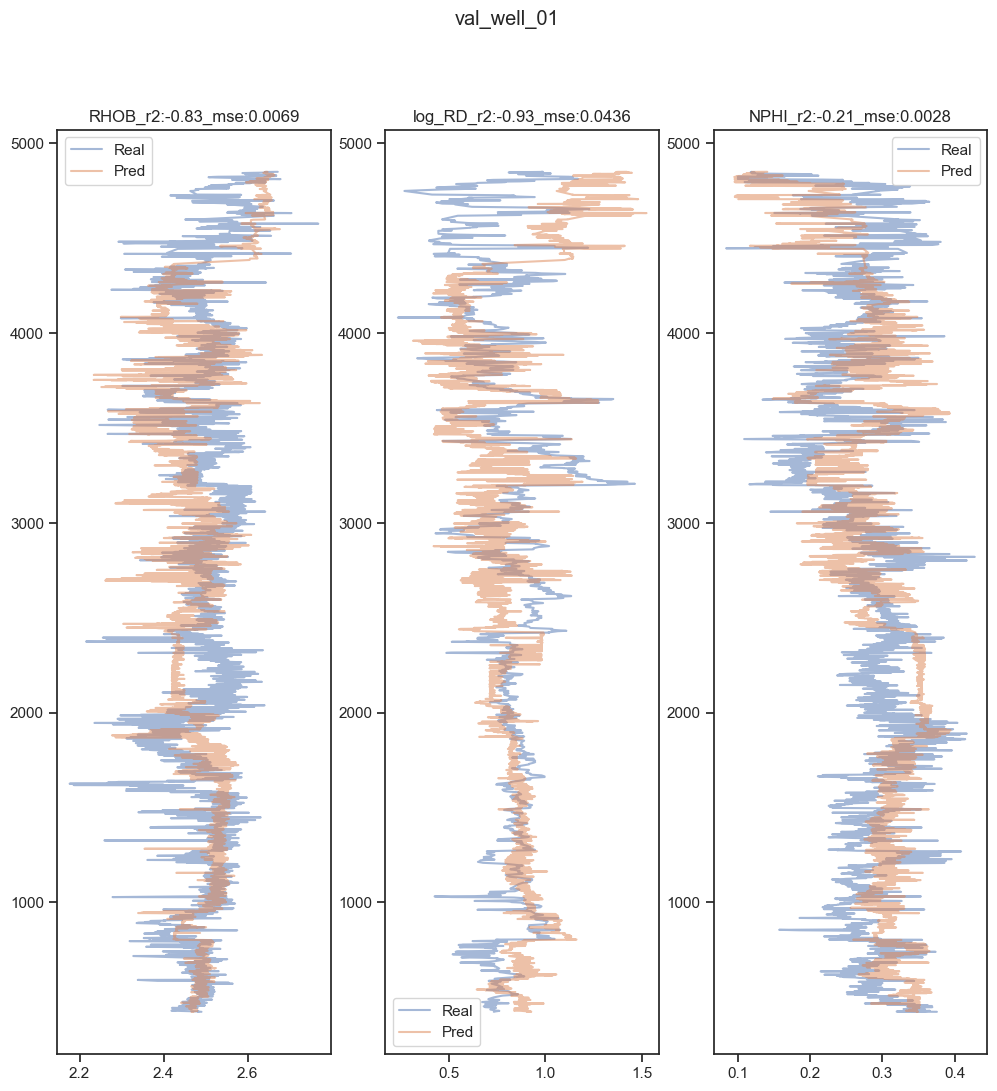

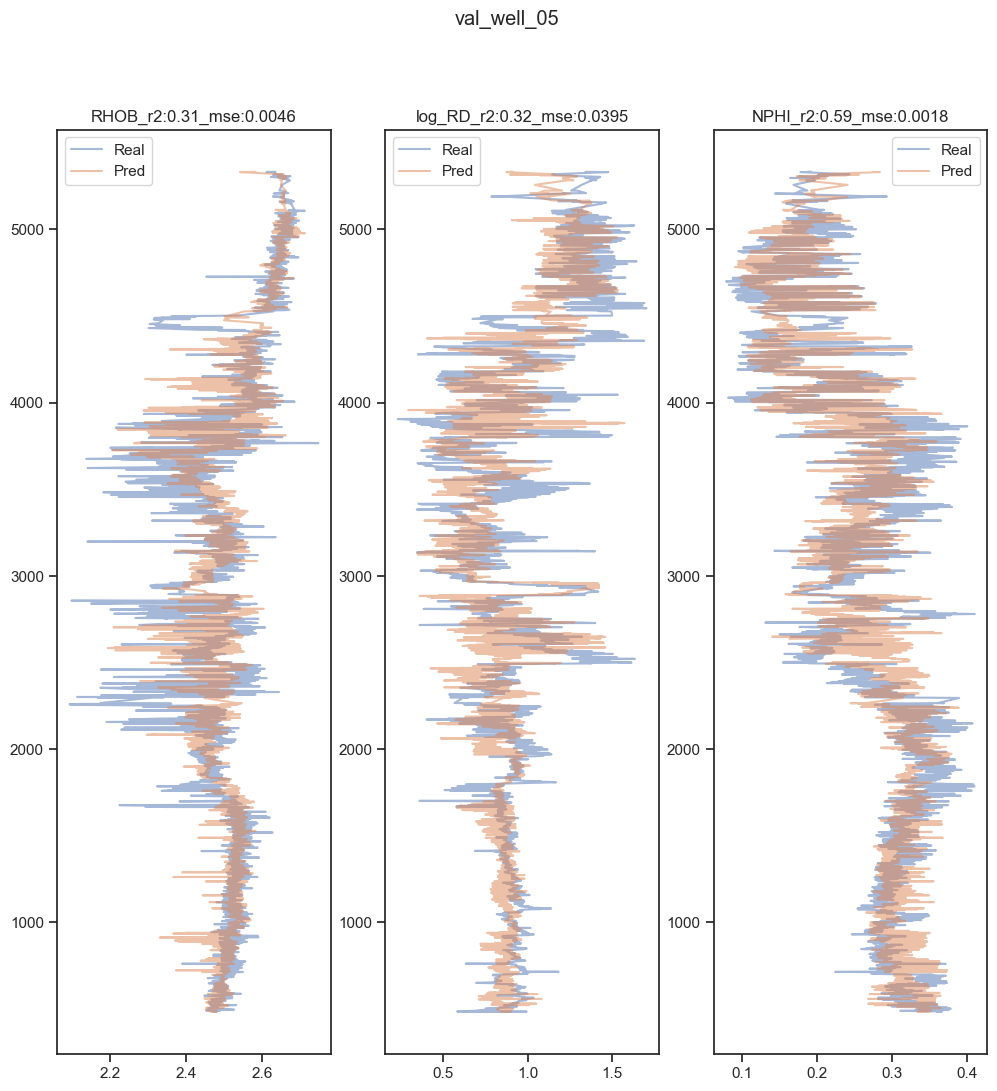

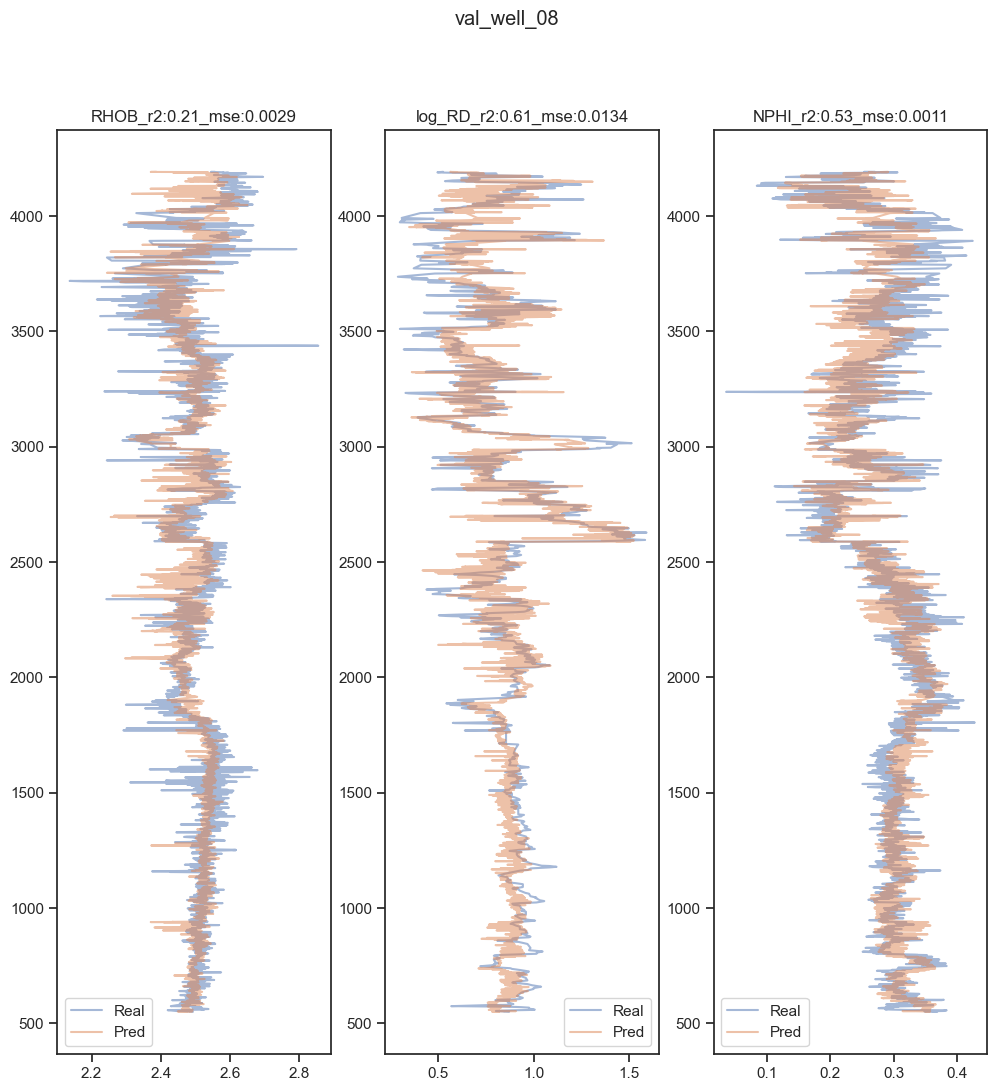

In [11]:
## Validation well plot

val_well_n = val_well['well'].unique()
y_feat = ['RHOB', 'log_RD', 'NPHI']
x_feat = ['DEPT', 'GR']


for _, i in enumerate(val_well_n):
    # plt.figure(figsize=(12,12))
    fig, axs = plt.subplots(1,3, figsize=(12,12))
    fig.suptitle('val_well_{}'.format(i))
    for j, feat in enumerate(y_feat):
        r2 = r2_score(val_well.loc[val_well['well']==i, feat], val_well.loc[val_well['well']==i, '{}_pred'.format(feat)])
        mse = mean_squared_error(val_well.loc[val_well['well']==i, feat], val_well.loc[val_well['well']==i, '{}_pred'.format(feat)])
        axs[j].plot(val_well.loc[val_well['well']==i, feat], val_well.loc[val_well['well']==i, 'DEPT'], label = 'Real', alpha=0.5)
        axs[j].plot(val_well.loc[val_well['well']==i, '{}_pred'.format(feat)], val_well.loc[val_well['well']==i, 'DEPT'], label = 'Pred', alpha=0.5)
        axs[j].legend()
        axs[j].title.set_text('{}_r2:{:.2f}_mse:{:.4f}'.format(feat,r2,mse))
    # fig.savefig('Val/2/val_{}_ZonationX_scaledX.png'.format(i))

### 전체 로그 데이터에 대한 성능 평가

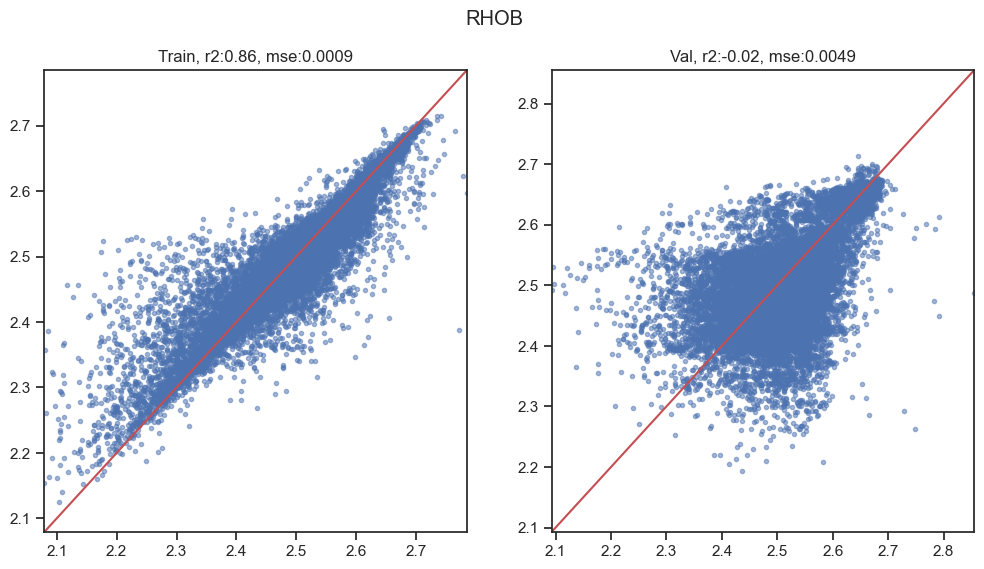

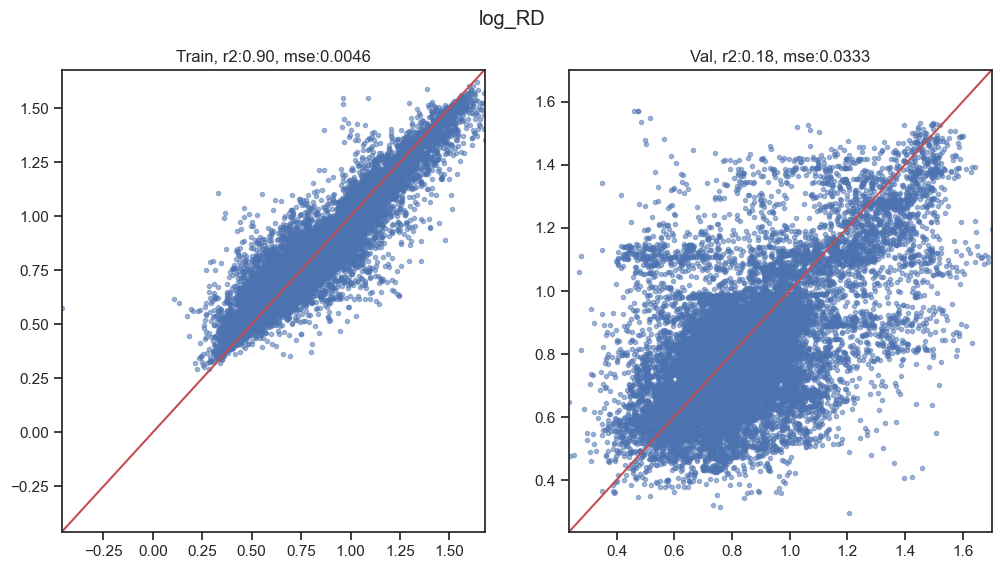

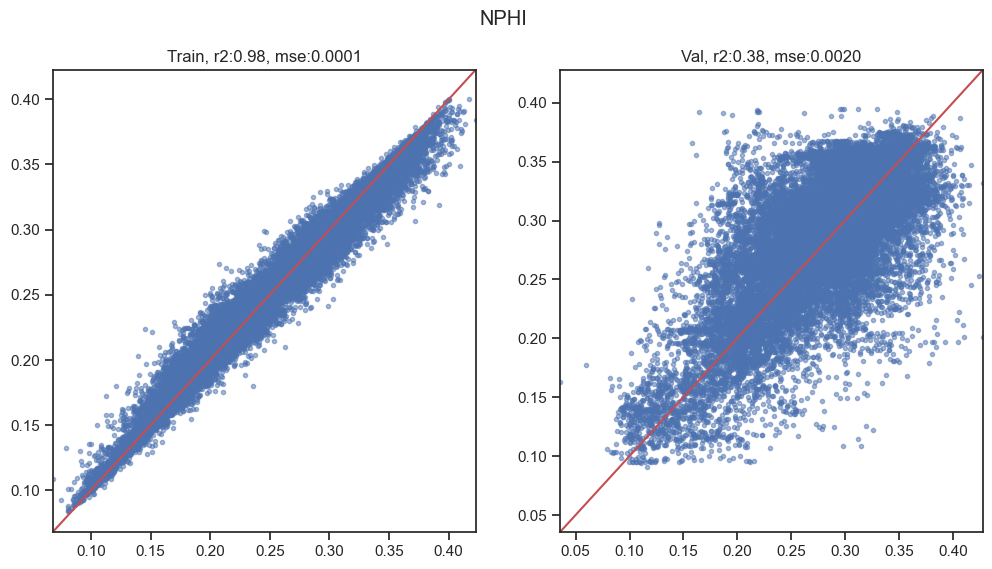

In [12]:
y_feat = ['RHOB', 'log_RD', 'NPHI']
for i, feat in enumerate(y_feat):
    x_min, x_max = train_well[feat].min(), train_well[feat].max()
    solid_line = [x_min, x_max]

    x_min2, x_max2 = val_well[feat].min(), val_well[feat].max()
    solid_line2 = [x_min2, x_max2]
    r2_train = r2_score(train_well[feat], train_well['{}_pred'.format(feat)])
    r2_val = r2_score(val_well[feat], val_well['{}_pred'.format(feat)])
    mse_train = mean_squared_error(train_well[feat], train_well['{}_pred'.format(feat)])
    mse_val = mean_squared_error(val_well[feat], val_well['{}_pred'.format(feat)])


    plt.figure(figsize=(12,6))

    plt.suptitle('{}'.format(feat))
    
    plt.subplot(121)
    plt.plot(train_well[feat], train_well['{}_pred'.format(feat)], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)
    plt.title('Train, r2:{:.2f}, mse:{:.4f}'.format(r2_train, mse_train))

    plt.subplot(122)
    plt.plot(val_well[feat], val_well['{}_pred'.format(feat)], '.', alpha=0.5)
    plt.plot(solid_line2, solid_line2, c='r')
    plt.xlim(x_min2, x_max2)
    plt.ylim(x_min2, x_max2)
    plt.title('Val, r2:{:.2f}, mse:{:.4f}'.format(r2_val, mse_val))

    # plt.savefig('Val/2/{}_ZoneationX_1.png'.format(feat))

In [ ]:
# y_feat = ['RHOB', 'log_RD', 'NPHI']
# for i, feat in enumerate(y_feat):
#     x_min, x_max = val_well[feat].min(), val_well[feat].max()
#     solid_line = [x_min, x_max]
#     r2 = r2_score(val_well[feat], val_well['{}_pred'.format(feat)])

#     plt.figure(figsize=(12,12))

#     plt.suptitle('{}'.format(feat))

#     plt.subplot(221)
#     plt.plot(val_well[feat], val_well['{}_pred'.format(feat)], '.', alpha=0.5)
#     plt.plot(solid_line, solid_line, c='r')
#     plt.xlim(x_min, x_max)
#     plt.ylim(x_min, x_max)
#     plt.title('Random Forest, r2:{:.2f}'.format(r2))

#     # plt.subplot(222)
#     # plt.plot(val_well[feat], y_train_pred_xg[:,i], '.', alpha=0.5)
#     # plt.plot(solid_line, solid_line, c='r')
#     # plt.xlim(x_min, x_max)
#     # plt.ylim(x_min, x_max)
#     # plt.title('XGBoost, r2:{:.2f}'.format(r2_xg[i]))

#     # plt.subplot(223)
#     # plt.plot(val_well[feat], y_train_pred_svm[:, i], '.', alpha=0.5)
#     # plt.plot(solid_line, solid_line, c='r')
#     # plt.xlim(x_min, x_max)
#     # plt.ylim(x_min, x_max)
#     # plt.title('SVR, r2:{:.2f}'.format(r2_svm[i]))

#     # plt.subplot(224)
#     # plt.plot(val_well[feati], y_train_pred_light[:, i], '.', alpha=0.5)
#     # plt.plot(solid_line, solid_line, c='r')
#     # plt.xlim(x_min, x_max)
#     # plt.ylim(x_min, x_max)
#     # plt.title('Light GBM, r2:{:.2f}'.format(r2_light[i]))

In [ ]:
# for i in range(3):
#     x_min, x_max = y_val[:,i].min(), y_val[:,i].max()
#     solid_line = [x_min, x_max]

#     plt.figure(figsize=(12,12))

#     plt.suptitle('{}'.format(Feature_name[i]))

#     plt.subplot(221)
#     plt.plot(y_val[:,i], y_val_pred_rf[:,i], '.', alpha=0.5)
#     plt.plot(solid_line, solid_line, c='r')
#     plt.xlim(x_min, x_max)
#     plt.ylim(x_min, x_max)
#     plt.title('Random Forest, r2:{:.2f}'.format(r2_rf_val[i]))

#     plt.subplot(222)
#     plt.plot(y_val[:,i], y_val_pred_xg[:,i], '.', alpha=0.5)
#     plt.plot(solid_line, solid_line, c='r')
#     plt.xlim(x_min, x_max)
#     plt.ylim(x_min, x_max)
#     plt.title('XGBoost, r2:{:.2f}'.format(r2_xg_val[i]))

#     plt.subplot(223)
#     plt.plot(y_val[:,i], y_val_pred_svm[:, i], '.', alpha=0.5)
#     plt.plot(solid_line, solid_line, c='r')
#     plt.xlim(x_min, x_max)
#     plt.ylim(x_min, x_max)
#     plt.title('SVR, r2:{:.2f}'.format(r2_svm_val[i]))

#     plt.subplot(224)
#     plt.plot(y_val[:, i], y_val_pred_light[:, i], '.', alpha=0.5)
#     plt.plot(solid_line, solid_line, c='r')
#     plt.xlim(x_min, x_max)
#     plt.ylim(x_min, x_max)
#     plt.title('Light GBM, r2:{:.2f}'.format(r2_light_val[i]))

## 파이프라인 구축

In [ ]:
# # 파이프라인 구축
# rf_reg = RandomForestRegressor()
# xg_reg = xgboost.XGBRFRegressor()
# light_reg = lightgbm.LGBMRegressor()
# svm_reg = SVR()

# pipeline = Pipeline([
#     ('rf_reg', rf_reg),
#     ('xg_reg', xg_reg),
#     ('light_reg', light_reg),
#     ('svm_reg', svm_reg)
# ])

## 검증 유정 평가 지표

### Misaligned 자료 만들기

In [13]:
def random_stretch(curve,depth0,ank_p=0.4):

    length=curve.shape[0]
    assert depth0.shape[0]==curve.shape[0], "depth and curve do not match!"
    depth=depth0.copy()
    # find location after perturbation
    n=int(length*ank_p)
    np.random.seed()
    anchor_points0=np.sort(np.random.choice(np.arange(0,length),n,replace=False))
    anchor_points1=np.sort(np.random.choice(np.arange(0,length),n,replace=False))

    depth1=np.interp(depth,depth[anchor_points0],depth[anchor_points1],left=-99999,right=99999)
    good=(-99999<depth1)*(depth1<99999)
    depth1[depth1==99999]=depth1[good][-1]-depth[good][-1]+depth[depth1==99999]
    depth1[depth1==-99999]=depth1[good][0]-depth[good][0]+depth[depth1==-99999]
    f=interpolate.interp1d(depth1,curve,fill_value=(curve[0], curve[-1]), bounds_error=False,kind=1)
    new_curve=f(depth0)+np.random.normal(0,0.0001,curve.shape) # values of perturbed log
    new_depth=np.interp(depth0, depth1, depth0,left=depth0[0],right=depth0[-1]) #truth depth of perturbed log
    return new_curve,new_depth  

In [16]:
# Misaligned된 자료 생성
val_well['RD_pred'] = 10 ** (val_well['log_RD_pred'])
Y_feat = ['RHOB', 'NPHI', 'RD']
for i in Y_feat:
    val_well[i+'_raw']=np.nan
    val_well[i+'_dept']=np.nan
for i in val_well['well'].unique():
    idx=val_well['well']==i
    for j in Y_feat:
        val_well.loc[idx,j+'_raw'],val_well.loc[idx,j+'_dept']=random_stretch(val_well.loc[idx,j].values,val_well.loc[idx,'DEPT'].values)

In [18]:
# Misaligned된 자료에 DTW를 적용하여 Aligned 자료로 변환

dfs_val = dict(tuple(val_well.groupby('well')))
N = 101
for well in list(dfs_val.keys()):
    for mykey in Y_feat:
        ref=dfs_val[well][f'{mykey}_pred'].values
        query=dfs_val[well][f'{mykey}_raw'].values

        query=(query-query.mean())/query.std()*ref.std()+ref.mean()

        alignmentOBE = dtw(query,ref,
                             step_pattern="asymmetric",# dist=lambda x, y: 10000000-x*y,
                             window_type="sakoechiba", window_size=201)
        mypath=alignmentOBE.get_warping_path(target="reference")
        dfs_val[well][f'{mykey}_dept_pred']=dfs_val[well]['DEPT'].values[mypath]
        
        f=interpolate.interp1d(dfs_val[well]['DEPT'].values[mypath]+0.0000001*np.arange(dfs_val[well]['DEPT'].values.size),dfs_val[well][f'{mykey}_raw'].values,
                               fill_value=(dfs_val[well][f'{mykey}_raw'].values[0], dfs_val[well][f'{mykey}_raw'].values[-1]), 
                               bounds_error=False,kind=1)
        dfs_val[well][f'{mykey}_val_pred']=f(dfs_val[well]['DEPT'].values)

        
    
        # plt.figure()
        # plt.plot(dfs_val[well]['DEPT'].values,dfs_val[well][f'{mykey}'].values,alpha=0.5,label='Truth log')
        # plt.plot(dfs_val[well][f'{mykey}_dept_pred'].values,dfs_val[well][f'{mykey}_raw'].values,alpha=0.5,label='Aligned log')
        # plt.legend()
        # plt.show()

### 평가지표 확인

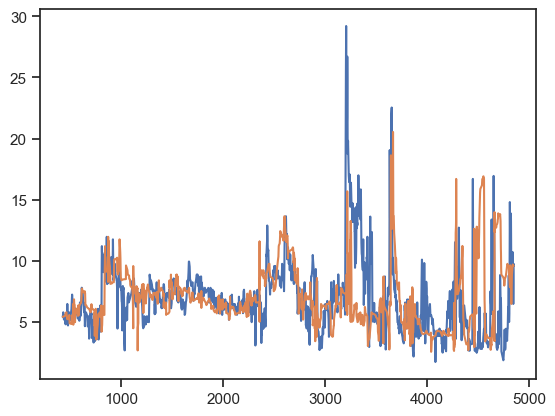

In [22]:
# True와 보정된 Pred 비교
feat = 'RD'
num = '01'
plt.plot(dfs_val[num]['DEPT'], dfs_val[num][feat])
plt.plot(dfs_val[num]['{}_dept_pred'.format(feat)], dfs_val[num]['{}_val_pred'.format(feat)])

In [23]:
dfs_val_all=pd.concat([dfs_val[mykey] for mykey in dfs_val.keys()])

In [24]:
val_true = np.asarray(dfs_val_all[Y_feat].values)
val_pred = np.asarray(dfs_val_all[['{}_val_pred'.format(i) for i in Y_feat]].values)
NMSE = np.sum((val_pred - val_true)**2)/(np.var(val_true)*val_true.shape[0]*val_true.shape[1])
print('검증 자료의 NMSE: {}'.format(NMSE))

검증 자료의 NMSE: 0.21522597978778993


In [25]:
val_dept_true = np.asarray(dfs_val_all[['{}_dept'.format(i) for i in Y_feat]].values)
val_dept_pred = np.asarray(dfs_val_all[['{}_dept_pred'.format(i) for i in Y_feat]].values)
MAD = np.sum(np.abs(val_dept_true-val_dept_pred)/(val_dept_true.shape[0]*val_dept_true.shape[1]))
print('검증 자료의 MAE: {}'.format(MAD))

검증 자료의 MAE: 42.604631119365784


## 테스트 자료 예측

In [26]:
# 테이트 자료 불러오기
test_well_list = os.listdir('data/test/')

if 'README.md' in test_well_list:
    test_well_list.remove('README.md')

test_per_well = []

for i in test_well_list:
    well = pd.read_csv('data/test/{}'.format(i))
    well['well'] = int(i.split('_')[-1].split('.')[0])
    test_per_well.append(well)

In [27]:
# 정성적 Zonation
test_per_well[0].loc[:, 'Zone'] = 2
test_per_well[0].loc[test_per_well[0]['DEPT']<=4279, 'Zone'] = 1
test_per_well[0].loc[test_per_well[0]['DEPT']<=3132.5, 'Zone'] = 0

test_per_well[1].loc[:, 'Zone'] = 2
test_per_well[1].loc[test_per_well[1]['DEPT']<=3912.5, 'Zone'] = 1
test_per_well[1].loc[test_per_well[1]['DEPT']<=2774.5, 'Zone'] = 0

test_per_well[2].loc[:, 'Zone'] = 2

test_per_well2 = pd.concat(test_per_well)

In [30]:
# 학습 모델을 이용하여 테스트 로그 데이터 예측
test_well = test_per_well2[['DEPT', 'GR', 'Zone', 'well']].copy()

test_well['DEPT'] = scaler1.fit_transform(np.asarray(test_well['DEPT']).reshape(-1,1))
test_well['GR'] = scaler2.fit_transform(np.asarray(test_well['GR']).reshape(-1,1))

for i in test_well['Zone'].unique():
    test_well.loc[test_well['Zone']==i,'NPHI'] = models[i][0].predict(test_well.loc[test_well['Zone']==i, ['DEPT', 'GR']])
    
    test_well.loc[test_well['Zone']==i,'RHOB'] = models[i][1].predict(test_well.loc[test_well['Zone']==i, ['DEPT', 'GR', 'NPHI']])
    
    test_well.loc[test_well['Zone']==i,'log_RD'] = models[i][2].predict(test_well.loc[test_well['Zone']==i, ['DEPT', 'GR', 'NPHI', 'RHOB']])

test_well['NPHI'] = scaler3.transform(np.asarray(test_well['NPHI']).reshape(-1,1))
test_well['RHOB'] = scaler4.transform(np.asarray(test_well['RHOB']).reshape(-1,1))
test_well['log_RD'] = scaler5.transform(np.asarray(test_well['log_RD']).reshape(-1,1))

test_well['RD'] = 10 ** test_well['log_RD']

test_per_well2['NPHI_pred'] = test_well['NPHI'].copy()
test_per_well2['RHOB_pred'] = test_well['NPHI'].copy()
test_per_well2['RD_pred'] = 10 ** test_well['NPHI'].copy()

In [31]:
# 예측한 로그 데이터를 ref로 이용하여 기존 misaligned된 로그 데이터를 DTW에 적용
Y_feat = ['NPHI', 'RHOB', 'RD']

N = 101
for well in test_per_well2['well'].unique():
    for mykey in Y_feat:
        ref=test_per_well2.loc[test_per_well2['well']==well, f'{mykey}_pred'].values
        query=test_per_well2.loc[test_per_well2['well']==well ,f'{mykey}'].values
                                 
        query=(query-query.mean())/query.std()*ref.std()+ref.mean()

        alignmentOBE = dtw(query,ref,
                             step_pattern="asymmetric",# dist=lambda x, y: 10000000-x*y,
                             window_type="sakoechiba", window_size=201)
        mypath=alignmentOBE.get_warping_path(target="reference")
        test_per_well2.loc[test_per_well2['well']==well,f'{mykey}_dept_pred']=test_per_well2.loc[test_per_well2['well']==well,'DEPT'].values[mypath]
        
        f=interpolate.interp1d(test_per_well2.loc[test_per_well2['well']==well,'DEPT'].values[mypath]+0.0000001*np.arange(test_per_well2.loc[test_per_well2['well']==well,'DEPT'].values.size),test_per_well2.loc[test_per_well2['well']==well,f'{mykey}'].values,
                               fill_value=(test_per_well2.loc[test_per_well2['well']==well,f'{mykey}'].values[0], test_per_well2.loc[test_per_well2['well']==well,f'{mykey}'].values[-1]), 
                               bounds_error=False,kind=1)
        test_per_well2.loc[test_per_well2['well']==well,f'{mykey}_pred']=f(test_per_well2.loc[test_per_well2['well']==well,'DEPT'].values)

        
    
        # plt.figure()
        # plt.plot(test_per_well2.loc[test_per_well2['well']==well,'DEPT'].values,test_per_well2.loc[test_per_well2['well']==well,f'{mykey}'].values,alpha=0.5,label='Truth log')
        # plt.plot(test_per_well2.loc[test_per_well2['well']==well,f'{mykey}_dept_pred'].values,test_per_well2.loc[test_per_well2['well']==well,f'{mykey}_raw'].values,alpha=0.5,label='Aligned log')
        # plt.legend()
        # plt.show()

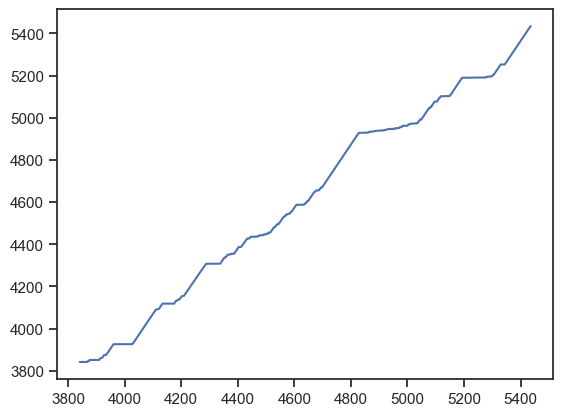

In [32]:
# Warping 경로 플랏
plt.plot(test_per_well2.loc[test_per_well2['well']==well, 'DEPT'], test_per_well2.loc[test_per_well2['well']==well, 'RHOB_dept_pred'])

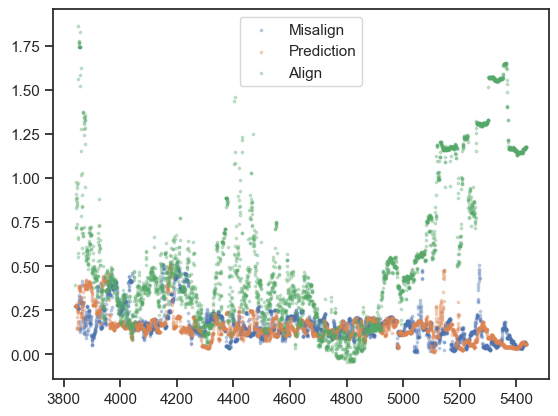

In [25]:
well = 3
plt.scatter(test_per_well2.loc[test_per_well2['well'] == well, 'DEPT'], test_per_well2.loc[test_per_well2['well'] == well, 'NPHI'], alpha=0.3, s=3, label = 'Misalign')
plt.scatter(test_per_well2.loc[test_per_well2['well'] == well, 'DEPT'], test_per_well2.loc[test_per_well2['well'] == well, 'NPHI_pred'], alpha=0.3, s=3, label = 'Prediction')
plt.scatter(test_per_well2.loc[test_well['well'] == well, 'DEPT'], test_well.loc[test_per_well2['well'] == well, 'NPHI'], alpha=0.3, s=3, label = 'Align')
plt.legend()

plt.show()

In [ ]:
# Test 예측 결과 excel 추출
for well in test_per_well2['well'].unique():
    test_per_well2.loc[test_per_well2['well']==well].to_excel('result/{}.xlsx'.format(well))

### 실험실

In [ ]:
# # Median filter
# window_size = 200
# window = []
# for i in range(len(per_well[0]['GR'])):
#     if i < window_size//2 :
#         window.append(np.median(per_well[0]['GR'][:i]))
#     elif i > len(per_well[0]) - window_size//2 :
#         window.append(np.median(per_well[0]['GR'][i-window_size//2:-1]))
#     else:
#         window.append(np.median(per_well[0]['GR'][i-window_size//2:i+window_size//2]))

c:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\DELL\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
